<a href="https://colab.research.google.com/github/DerrickFeiWang/IMDB/blob/main/IMDB_US_Movie_Title_and_Vote_BERT_Sentence_Embedding_20201231.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install -U sentence-transformers scipy

     |████████████████████████████████| 71kB 7.3MB/s 
     |████████████████████████████████| 25.9MB 122kB/s 
     |████████████████████████████████| 1.5MB 47.1MB/s 
     |████████████████████████████████| 1.1MB 53.2MB/s 
     |████████████████████████████████| 890kB 56.4MB/s 
     |████████████████████████████████| 2.9MB 45.3MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.0-cp36-none-any.whl size=102655 sha256=7d6e1682e57516a32dda8cd47b27f56cfbef7fb15f6d8d3877e9e69013c53cdb
  Stored in directory: /root/.cache/pip/wheels/ff/76/65/50258d8b7930e909ea2f5bd006a23d520a16765af13ab45bb3
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=86fb8b2ee5128caf28f3a3f80943877703b31a9a76f5163c5358ee1b80adc04f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7

In [29]:
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:14<00:00, 27.5MB/s]


In [30]:
import pandas as pd, numpy as np
raw_df = pd.read_csv(r'https://raw.githubusercontent.com/derrickfwang/IMDB/main/df_us_movie_title_votes.csv')
raw_df.head()

,tconst,primaryTitle,titleLength,numVotes,logVotes,averageRating
0,tt0035423,Kate & Leopold,3,78674,4.895831,6.4
1,tt0081145,Me and the Kid,4,244,2.387390,5.4
2,tt0088751,The Naked Monster,3,274,2.437751,5.4
3,tt0095840,Payback,1,53,1.724276,4.6
4,tt0095878,Pledge Night,2,624,2.795185,4.8


# Sentence Enbedding

In [31]:
raw_df['SentenceEmbedding'] = raw_df['primaryTitle'].apply(lambda x: embedder.encode([x])[0])

In [32]:
# convert to 3 digit decimals to get faster processing
def convertToThreeDigit(x):
  x = np.array(x)
  x = x.astype(np.float)
  x = np.around(x, decimals=3)
  return x

x = [-4.18622196e-01, 3.96415532e-01, -2.27945328e-01, -8.94242465e-01]
convertToThreeDigit(x)

array([-0.419,  0.396, -0.228, -0.894])

In [33]:
raw_df['SentenceEmbedding'] = raw_df['SentenceEmbedding'].apply(convertToThreeDigit)

In [34]:
raw_df.head(3)


,tconst,primaryTitle,titleLength,numVotes,logVotes,averageRating,SentenceEmbedding
0,tt0035423,Kate & Leopold,3,78674,4.895831,6.4,"[-0.529, 0.331, 1.651, 0.013, 0.507, 0.225, -0..."
1,tt0081145,Me and the Kid,4,244,2.387390,5.4,"[0.124, -0.579, 1.473, 0.804, 0.441, 0.553, -1..."
2,tt0088751,The Naked Monster,3,274,2.437751,5.4,"[0.158, 1.162, 0.495, 0.588, -0.355, -0.305, 1..."


# K-means Clustering

In [35]:
import random
random.seed(9001)


X_Sample = raw_df['SentenceEmbedding']
X_Sample = np.stack(X_Sample)  
X_Sample.shape

(59743, 768)

In [36]:
import sys
sys.getsizeof(X_Sample)

367061104

In [37]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

kmeans = KMeans(n_clusters=100, random_state=0).fit(X_Sample)
Y=kmeans.labels_
raw_df['clusters'] = Y

In [38]:
# Check number of movies in each cluster
raw_df.clusters.value_counts()

39    1822
91    1524
18    1417
80    1280
53    1269
24    1222
72    1210
43    1182
40    1112
4      957
13     956
20     953
37     895
19     892
1      864
65     849
50     824
17     818
93     792
16     761
78     760
71     757
64     743
32     739
42     706
23     705
54     702
10     698
89     686
49     684
94     681
60     657
44     655
67     650
31     633
8      631
77     622
45     608
14     602
82     599
6      597
52     590
66     584
35     573
63     564
87     555
95     543
5      530
3      530
25     525
9      521
88     519
51     518
90     516
47     503
26     503
97     500
46     493
34     483
22     474
96     473
70     464
59     463
12     463
11     462
57     453
76     451
75     451
36     449
69     443
73     442
21     432
85     423
81     418
30     413
86     393
2      392
41     391
68     391
58     387
83     384
61     364
0      360
28     353
55     344
74     335
7      328
56     320
98     312
99     294
92     267

# Visualizing the clustering results with t-SNE

In [39]:
# using 10,000 random samples to run t-SNE
import random
RandIdx = random.sample(range(len(raw_df)), 10000)
X_Sample_S = raw_df['SentenceEmbedding'][RandIdx]
Y_Sample_S =raw_df['clusters'][RandIdx]

In [40]:
X_Sample_S = np.stack(X_Sample_S)
X_Sample_S.shape

(10000, 768)

In [41]:
Y_Sample_S.shape

(10000,)

In [42]:
digits_proj = TSNE(random_state=0).fit_transform(X_Sample_S)

In [43]:
digits_proj.shape

(10000, 2)

In [44]:
# function to create scatter plot of vectors
def scatter(x, colors, n_clusters):
    # choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", n_clusters))

    # create a scatter plot.
    f = plt.figure(figsize=(15, 15))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=30,
                    c=palette[colors.astype(np.int)])

    ax.axis('off')
    ax.axis('tight')

    # add the labels for each cluster.
    txts = []
    for i in range(n_clusters):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=12)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 1080x1080 with 1 Axes>,
 [Text(-39.784294, -10.338337, '0'),
  Text(28.541847, -27.513857, '1'),
  Text(-37.886646, 44.204712, '2'),
  Text(-46.71467, 31.76757, '3'),
  Text(70.13066, -8.567008, '4'),
  Text(-66.88498, 0.46859452, '5'),
  Text(34.316494, 37.939766, '6'),
  Text(47.905643, 41.308136, '7'),
  Text(-1.2609322, 54.781868, '8'),
  Text(-7.483952, 38.88736, '9'),
  Text(70.858826, -20.002342, '10'),
  Text(-8.004293, 17.254883, '11'),
  Text(47.0658, -3.3211584, '12'),
  Text(16.225796, -32.531296, '13'),
  Text(2.2244918, -30.206482, '14'),
  Text(-51.525658, 1.3344388, '15'),
  Text(22.145878, 1.9625857, '16'),
  Text(-23.82763, 62.581253, '17'),
  Text(30.515747, -11.2970085, '18'),
  Text(53.748646, -16.34205, '19'),
  Text(-24.653605, 36.25625, '20'),
  Text(-8.035393, -23.443695, '21'),
  Text(29.440052, -54.810753, '22'),
  Text(-4.3654966, -39.22065, '23'),
  Text(0.19296935, 9.231277, '24'),
  Text(-66.815, 25.962666, '25'),
  Text(-38.721333, -29.8060

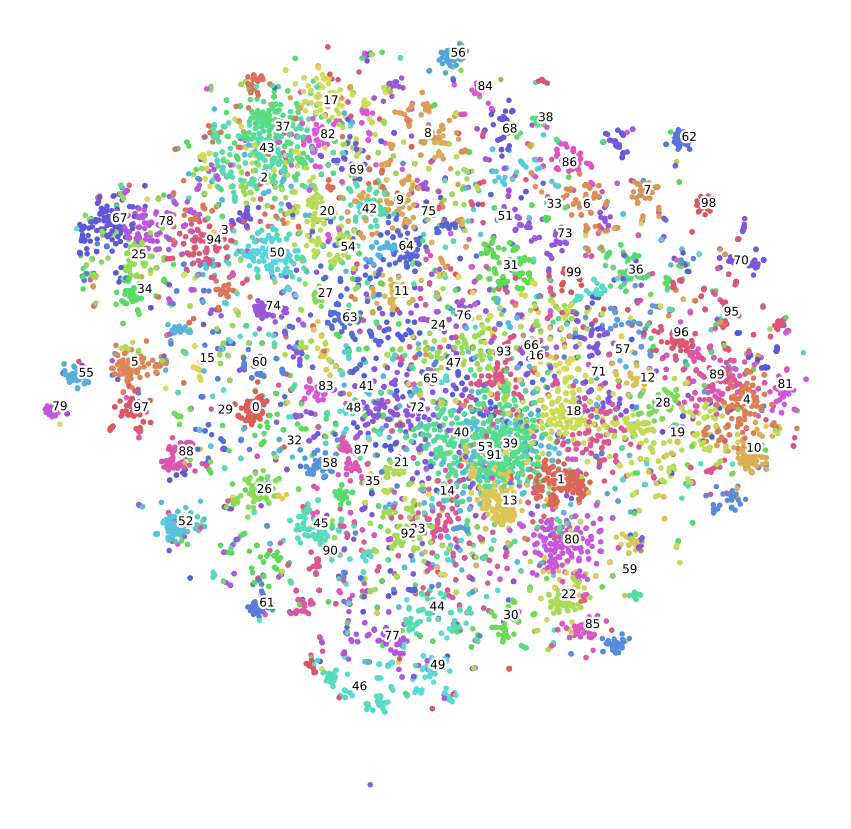

In [45]:
import matplotlib.patheffects as PathEffects, matplotlib.pyplot as plt
import seaborn as sns

scatter(digits_proj, Y_Sample_S, 100)

# Draw Dendrogram Using Raw Embedding Data

In [46]:
dfR = pd.DataFrame(X_Sample)
dfR['clusters'] = Y
dfR2 = dfR.groupby(['clusters']).mean()
nparray1 = dfR2.values

In [47]:
len(dfR)

59743

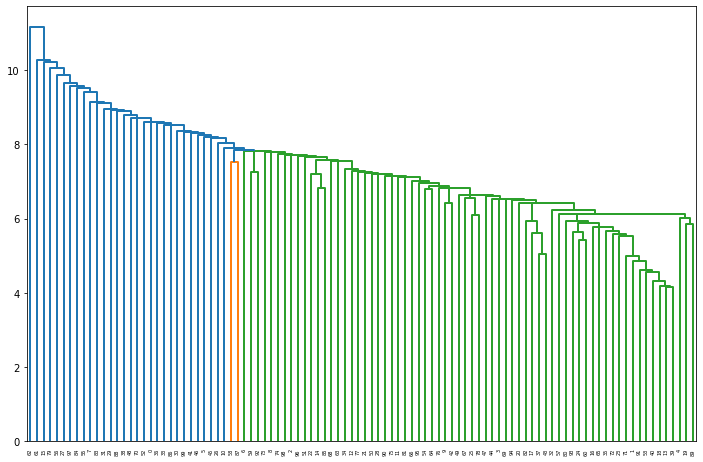

In [48]:
from scipy.cluster import hierarchy
import matplotlib

matplotlib.rcParams['lines.linewidth'] = 2 #Force to change line width

Z = hierarchy.linkage(nparray1, 'single')
plt.figure(figsize = (12,8))
dn = hierarchy.dendrogram(Z)

# Statistics of each cluster

In [49]:
xx = raw_df[['clusters','numVotes']].groupby('clusters').describe().reset_index()
xx.columns = ['clusters','count','mean','std','min','25%','median','75%','max']
xx = xx.sort_values(by = 'median', ascending=False)
xx.head()

,clusters,count,mean,std,min,25%,median,75%,max
63,63,564.0,63744.824468,190762.823331,5.0,68.75,703.5,8155.75,2285943.0
13,13,956.0,4905.654812,21686.116030,5.0,72.00,476.5,2427.50,485457.0
21,21,432.0,24005.520833,76300.753502,5.0,50.75,445.5,5573.50,989853.0
22,22,474.0,10587.379747,38994.812218,5.0,45.00,362.0,2975.75,550883.0
80,80,1280.0,10456.011719,40423.447875,5.0,43.00,324.5,2671.25,699901.0


In [50]:
pd.options.display.max_rows=100
xx.tail()

,clusters,count,mean,std,min,25%,median,75%,max
12,12,463.0,5555.606911,38081.868021,5.0,20.5,96.0,741.0,695521.0
84,84,189.0,7272.809524,31339.538124,5.0,26.0,93.0,554.0,293566.0
27,27,221.0,5654.171946,42101.139671,5.0,21.0,88.0,350.0,517634.0
26,26,503.0,4549.204771,29734.373053,5.0,14.0,60.0,592.5,538539.0
32,32,739.0,5750.434371,37034.486881,5.0,17.0,53.0,358.5,592441.0


In [51]:
raw_df[['tconst', 'primaryTitle', 'numVotes', 'logVotes', 
       'clusters']].to_excel('IMDB_US_Movie_Title_Votes.xlsx', index=False)

In [52]:
#raw_df = pd.read_excel('IMDB_US_Movie_Title_Votes.xlsx')

In [53]:
raw_df[['tconst','primaryTitle','clusters', 'numVotes']].query("clusters == 63").head(30)

,tconst,primaryTitle,clusters,numVotes
117,tt0099892,Joe Versus the Volcano,63,34411
189,tt0100758,Teenage Mutant Ninja Turtles,63,84954
206,tt0101255,9 1/2 Ninjas!,63,364
371,tt0103060,Teenage Mutant Ninja Turtles II: The Secret of...,63,51387
393,tt0103278,Wizards of the Demon Sword,63,487
549,tt0105399,Twin Dragons,63,10893
554,tt0105426,The Slammie Bros. vs. Godzilla and Gamera,63,29
635,tt0106761,Double Dragon,63,11205
740,tt0108074,The Eagle Shooting Heroes,63,2202
755,tt0108308,Teenage Mutant Ninja Turtles III,63,30847


In [54]:
raw_df[['tconst','primaryTitle','clusters', 'numVotes']].query("clusters == 32").head(30)

,tconst,primaryTitle,clusters,numVotes
7,tt0096845,Atlantic Rhapsody - 52 myndir úr Tórshavn,32,49
19,tt0098136,Prom Night III: The Last Kiss,32,1942
164,tt0100504,Rock 'n' Roll High School Forever,32,1098
288,tt0102180,Moonlight Sonata II: The Street Sweepers,32,409
376,tt0103121,Triple Bogey on a Par Five Hole,32,104
405,tt0103743,The Eight Immortals Restaurant: The Untold Story,32,3339
517,tt0104954,My New Gun,32,657
688,tt0107384,Leningrad Cowboys Meet Moses,32,1399
808,tt0109277,Sailor Moon S: The Movie - Hearts in Ice,32,1765
858,tt0109831,Four Weddings and a Funeral,32,138652


In [55]:
raw_df.head()


,tconst,primaryTitle,titleLength,numVotes,logVotes,averageRating,SentenceEmbedding,clusters
0,tt0035423,Kate & Leopold,3,78674,4.895831,6.4,"[-0.529, 0.331, 1.651, 0.013, 0.507, 0.225, -0...",80
1,tt0081145,Me and the Kid,4,244,2.387390,5.4,"[0.124, -0.579, 1.473, 0.804, 0.441, 0.553, -1...",30
2,tt0088751,The Naked Monster,3,274,2.437751,5.4,"[0.158, 1.162, 0.495, 0.588, -0.355, -0.305, 1...",25
3,tt0095840,Payback,1,53,1.724276,4.6,"[-0.679, -0.471, 1.816, 0.415, -0.254, 0.81, -...",23
4,tt0095878,Pledge Night,2,624,2.795185,4.8,"[0.677, -0.691, 2.043, 0.098, 0.37, -0.504, 0....",59


# Cluster Centers

In [56]:
df_center = pd.merge(pd.DataFrame(raw_df['SentenceEmbedding'].tolist()), raw_df['clusters'], left_index=True, right_index=True)
df_center = df_center.groupby(['clusters']).median()
df_center

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
clusters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.0265,0.1430,0.3655,0.1440,0.2940,-0.2560,0.1440,0.3480,0.2095,-0.0930,-0.2505,1.0265,0.2140,0.5350,0.0840,0.2865,-0.7640,-0.0840,-0.2925,-0.2075,-0.6760,-0.1010,0.2305,-0.3025,0.3795,-0.3150,0.2930,-1.6835,-1.2615,0.1220,-0.2960,-0.0885,0.0490,-0.0510,0.2635,0.8180,-0.3155,0.4015,0.0555,-0.2125,...,-0.4145,-0.7985,-0.4150,-0.2570,-0.0490,0.2595,0.9330,0.1910,-0.2050,-0.3560,-0.7245,-0.2600,-0.2700,-0.7535,-0.0515,-0.3440,0.0105,0.1125,-0.7895,0.6545,0.1250,0.0820,0.2605,-0.4510,0.7530,-0.3915,-0.4150,0.4690,0.4345,0.3540,0.1500,-0.1370,0.2760,0.3715,-0.1110,-0.5340,-0.3770,-0.1930,0.3330,-0.3960
1,-0.2180,-0.3880,1.8285,0.2880,0.6845,0.2865,-0.4415,0.9485,0.2635,-0.2580,-0.2925,0.8970,0.4450,0.5985,0.4770,0.3930,-0.3995,-0.3245,0.2440,-0.7295,0.0085,0.6200,-0.2305,-0.3825,-0.1655,-0.6680,0.0440,-1.6135,-0.2290,0.1775,0.0150,-0.0110,0.1660,-0.0975,-0.3265,0.7090,-0.3015,0.0785,-0.3115,-0.1845,...,-0.9990,-0.7735,-0.3820,0.1940,0.0585,0.4220,0.7810,0.3315,0.0745,0.1315,-0.1390,0.0695,-0.4750,-0.1565,0.1720,0.0780,-0.4140,-0.1670,-0.2780,0.2620,-0.2660,0.1755,0.2510,-0.2535,0.1150,-0.9260,-0.5325,0.4095,-0.1750,0.2265,0.3750,-0.5570,0.2420,0.3015,-0.1095,-0.5530,0.1785,-0.2920,-0.1955,0.1760
2,0.1245,0.0415,0.8010,0.0425,0.0445,0.5740,0.9390,0.1120,0.0325,0.2225,-0.3235,0.1720,0.2945,0.9360,0.1295,0.1545,-0.5270,-0.3960,0.0895,-0.4600,0.0440,-0.0535,0.5565,-0.8145,-0.0175,0.3620,0.2395,-0.5820,-1.1700,0.3770,-0.0505,-0.1910,0.6005,0.1675,0.2380,0.3885,0.0595,0.2930,-0.0905,-0.1200,...,-0.6155,-0.6010,0.5325,0.0100,-0.4370,0.0815,0.4780,-0.3265,0.7955,-0.5575,-0.5690,0.2695,-0.2035,0.5230,0.0760,-1.0750,-0.3440,-0.1020,0.1960,0.0050,-0.5660,0.2690,0.0955,0.6205,-0.1170,-0.0950,0.0720,-0.0400,-0.1705,-0.0975,-0.0945,-0.4240,-0.2060,-0.9280,-0.0180,-0.7840,-0.0115,-0.6220,0.0000,-0.0175
3,0.0075,0.1550,1.5535,0.2765,0.1660,0.7000,0.7960,0.3705,0.2080,-0.0875,-0.9725,0.1050,0.5965,0.6825,0.3530,0.1765,-0.4410,-0.5280,0.1930,-0.6785,-0.1035,0.2360,0.1410,-0.7530,-0.3035,-0.0695,-0.0650,-1.4050,-1.4330,0.0525,0.0210,0.4075,0.6950,0.1340,0.1580,0.4285,-0.1150,-0.6210,-0.1705,0.4900,...,-0.5050,-0.6410,0.3725,0.0050,-0.5105,-0.1235,0.3550,0.3330,0.4500,-0.0765,-0.3940,0.0265,-0.4190,0.8775,0.3375,-0.5165,0.1905,-0.4050,0.0215,0.1680,-0.4815,0.0265,0.6180,0.8720,-0.0730,0.0735,-0.1085,0.1840,-0.7560,-0.0205,0.2900,0.1330,0.4830,-0.8400,-0.1540,-0.3785,-0.2790,-0.1460,-0.2150,-0.2055
4,-0.1360,-0.3670,1.7350,0.4390,0.1620,-0.3350,-0.4470,0.5040,0.5460,-0.4060,-0.1600,0.3400,0.2380,0.3310,0.8770,0.0890,-0.4140,-0.4740,0.3820,-0.6840,-0.5250,-0.1240,-0.7010,-1.1350,-0.3880,-0.7940,-0.0020,-1.2420,0.0620,0.3140,-0.0190,0.7530,0.4300,-0.4110,0.1270,0.9580,0.2850,0.1120,-0.2670,-0.1290,...,-0.4980,-0.5140,0.5570,0.0400,-0.0890,0.5210,0.3240,0.0080,0.1400,-0.4520,-0.2780,0.6810,-0.5520,-0.0150,0.0320,-1.1010,-0.7490,-0.2930,0.0590,0.1290,-0.5210,-0.3800,0.6340,-0.5980,-0.5180,-0.4040,-0.5450,0.8400,-0.6250,-0.0280,-0.3620,-1.0010,0.5860,-1.3690,-0.1860,-0.5230,-0.3360,0.3260,-0.1140,0.0510
5,0.4890,-0.1110,1.0890,0.2605,0.2200,0.7710,0.9805,0.2205,0.0455,-0.2720,-0.9480,-0.1900,-0.0490,0.6250,1.2995,0.3070,-0.4505,-0.6740,-0.1510,-0.5020,0.0450,-0.1485,0.2895,-1.0010,-0.5395,-0.1970,0.0395,-0.3155,-1.1070,0.1400,0.1080,-0.1290,0.4705,-0.2015,0.5635,0.6820,-0.0850,-0.1410,0.0075,0.0640,...,-0.2470,-0.4795,0.3130,0.3900,-0.6475,0.2500,0.5385,-0.0310,0.6550,0.0265,-0.4245,0.2350,-0.8450,0.7370,0.6465,0.0775,0.3400,0.2545,0.2180,-0.1090,-0.9835,0.0960,0.3115,0.6800,-0.1260,-0.4035,-0.5240,-0.3245,-0.5030,-0.0100,0.2710,-0.0250,0.7045,-0.0655,-0.8360,-0.5875,0.1210,-0.3805,-0.1695,-0.152

In [57]:
centerArray = df_center.values
def getArrayComponent(i):
  return centerArray[i,]

In [58]:
getArrayComponent(0).shape

(768,)

In [59]:
df_Centers = pd.DataFrame(range(100), columns = ['clusters'])
df_Centers['embdSeries'] = df_Centers['clusters'].apply(getArrayComponent)

type(df_Centers['embdSeries'][0])

numpy.ndarray

In [60]:
df_Centers.head()

,clusters,embdSeries
0,0,"[-0.0265, 0.143, 0.3655, 0.144, 0.294, -0.256,..."
1,1,"[-0.218, -0.388, 1.8285, 0.288, 0.684500000000..."
2,2,"[0.1245, 0.0415, 0.801, 0.042499999999999996, ..."
3,3,"[0.0075, 0.155, 1.5535, 0.2765, 0.166, 0.7, 0...."
4,4,"[-0.136, -0.367, 1.735, 0.439, 0.162, -0.335, ..."


In [61]:
def cosineSimilarity(x): 
  #x = (np.array(x))
  #x = x.astype(np.float) 
  return cosine_similarity(x,y)

def euclideanDistance(x, y):
  #x = (np.array(x))
  #x = x.astype(np.float)
  return np.linalg.norm(y-x)

def calculateSimilarity(x):
  return (1/1.01)**x

In [62]:
raw_df.head(1)

,tconst,primaryTitle,titleLength,numVotes,logVotes,averageRating,SentenceEmbedding,clusters
0,tt0035423,Kate & Leopold,3,78674,4.895831,6.4,"[-0.529, 0.331, 1.651, 0.013, 0.507, 0.225, -0...",80


In [63]:
def getMoviesAtCenterOfCluster(cluster):
  y = df_Centers['embdSeries'][cluster]
  raw_df['euclideanDistance'] = raw_df['SentenceEmbedding'].apply(lambda x: euclideanDistance(x, y))
  raw_df['Similarity'] = raw_df['euclideanDistance'].apply(calculateSimilarity)
  idx = np.argsort(raw_df.euclideanDistance)[:20]
  return raw_df[['tconst', 'primaryTitle', 'numVotes', 'averageRating',
       'euclideanDistance','Similarity','clusters']].iloc[idx]

In [74]:
getMoviesAtCenterOfCluster(63).iloc[3:]

,tconst,primaryTitle,numVotes,averageRating,euclideanDistance,Similarity,clusters
43568,tt12876132,Deathstroke Knights & Dragons: The Movie,1288,6.4,9.587492,0.909010,63
42403,tt0142242,Dragon Ball Z: Broly - The Legendary Super Saiyan,9503,7.5,9.739680,0.907635,63
44216,tt2263944,Dragon Ball Z: Battle of Gods,26157,7.2,9.829733,0.906822,63
42161,tt0113187,Godzilla vs. Destoroyah,5448,7.0,9.890249,0.906276,63
554,tt0105426,The Slammie Bros. vs. Godzilla and Gamera,29,4.7,9.912567,0.906075,63
17587,tt0099388,Deathstalker IV: Match of Titans,749,3.7,9.959022,0.905656,63
44748,tt3819668,"Dragon Ball Z: Resurrection ""F""",20251,7.3,9.976781,0.905496,63
43407,tt1125254,Dragon Ball Z: Cooler's Revenge,6216,7.2,9.999228,0.905294,63
16681,tt7674116,Ninja Cowboy Viking vs. the GadgetGents,14,8.9,10.034404,0.904977,63
43712,tt1467280,Mega Monster Battle: Ultra Galaxy Legends - The Movie,251,6.7,10.044833,0.904883,63


In [79]:
pd.options.display.max_colwidth = 1000

In [80]:
getMoviesAtCenterOfCluster(32)

,tconst,primaryTitle,numVotes,averageRating,euclideanDistance,Similarity,clusters
54668,tt4368752,Bruce Springsteen & the E Street Band Houston '78 Bootleg: House Cut,10,7.7,10.063797,0.904712,32
11381,tt2131535,Hollywood Babble-On Live 5/22/2011,33,7.0,10.167285,0.903781,32
54093,tt10383464,"Asbury Park: Riot, Redemption, Rock & Roll",44,6.8,10.275626,0.902808,32
8652,tt1316091,Wreckless Epic: The Journey to SXSW,21,8.2,10.303474,0.902557,32
53979,tt0446071,We Jam Econo: The Story of the Minutemen,933,7.7,10.317333,0.902433,72
54828,tt7359702,David Gilmour: Live At Pompeii,752,8.8,10.474297,0.901025,32
15621,tt5892524,SXSW Comedy with Natasha Leggero,23,5.3,10.512047,0.900686,32
58506,tt1674783,The Savoy King: Chick Webb & the Music That Changed America,18,8.1,10.533840,0.900491,32
18826,tt3166672,Emmanuelle Through Time: Rod Steele 0014 & Naked Agent 0069,29,5.6,10.543430,0.900405,72
54674,tt4483862,Fantomas: The Director's Cut Live - A New Year's Revolution,10,8.2,10.574546,0.900126,32


In [66]:
getMoviesAtCenterOfCluster(27)

,tconst,primaryTitle,numVotes,averageRating,euclideanDistance,Similarity,clusters
48495,tt0463392,Zombie Nation,7875,2.0,5.633605,0.945486,27
13768,tt3712588,The Grid: Zombie Outlet Maul,13,4.9,5.635254,0.945470,27
50033,tt1844114,Zombie Doomsday,22,5.0,5.927116,0.942729,27
12499,tt2673854,Midget Zombie Takeover,90,4.7,5.946606,0.942546,27
6825,tt0902355,Zombie Hunters,18,4.1,5.951307,0.942502,27
50443,tt2287621,A Zombie Invasion,96,5.4,6.010017,0.941951,27
5400,tt0425528,Tele-Zombie,14,6.5,6.121649,0.940906,27
50440,tt2283089,Zombie Killer,8,6.1,6.126984,0.940856,27
12206,tt2446502,Zombie Hunter,2505,3.5,6.188475,0.940280,27
7926,tt1156398,Zombieland,517634,7.6,6.197460,0.940196,27


In [67]:
dfList = []
for cluster in range(100):
  dfx = getMoviesAtCenterOfCluster(cluster)
  dfx['ClusterCenter'] = cluster
  dfList.append(dfx)

dfClusterCenterMovies = pd.concat(dfList, axis = 0)


In [81]:
dfClusterCenterMovies.tail()

,tconst,primaryTitle,numVotes,averageRating,euclideanDistance,Similarity,clusters,ClusterCenter
824,tt0109403,Chasers,5772,5.2,8.396551,0.919847,99,99
45763,tt0120042,Running Time,1321,7.0,8.449077,0.919366,99,99
21673,tt2272918,Racing Hearts,4564,6.1,8.680301,0.917253,99,99
15917,tt6296236,Running Shaadi,2404,6.6,8.718160,0.916908,99,99
16022,tt6481002,Madea on the Run,328,4.8,8.722062,0.916872,99,99


In [82]:
dfClusterCenterMovies.to_excel('ClusterCenterMovies.xlsx', index=False)

In [71]:
dfClusterCenterMovies.tail(30)

,tconst,primaryTitle,numVotes,averageRating,euclideanDistance,Similarity,clusters,ClusterCenter
45545,tt8366590,Baaghi 3,8753,2.1,6.578290,0.936640,98,98
43859,tt1653690,Ong-bak 3,12998,5.0,6.583431,0.936592,98,98
22711,tt8475990,A Mero Hajur 3,74,5.5,6.679632,0.935696,98,98
32394,tt1611793,1 in 3,46,8.4,6.683282,0.935662,98,98
17456,tt9537352,Nikka Zaildar 3,234,4.1,6.694911,0.935554,98,98
9676,tt1588409,The Power of Three,37,5.5,6.725456,0.935270,98,98
48868,tt1014807,Rule of 3,134,5.0,6.726182,0.935263,98,98
21068,tt1188985,3some,1228,5.7,6.799358,0.934582,98,98
24767,tt0139576,Rule of Three,32,6.4,6.825197,0.934342,98,98
27074,tt0368343,Three Way,1398,4.7,6.938354,0.933290,98,98


In [77]:
5


5

In [78]:
dfClusterCenterMovies.tail(30)

,tconst,primaryTitle,numVotes,averageRating,euclideanDistance,Similarity,clusters,ClusterCenter
45545,tt8366590,Baaghi 3,8753,2.1,6.578290,0.936640,98,98
43859,tt1653690,Ong-bak 3,12998,5.0,6.583431,0.936592,98,98
22711,tt8475990,A Mero Hajur 3,74,5.5,6.679632,0.935696,98,98
32394,tt1611793,1 in 3,46,8.4,6.683282,0.935662,98,98
17456,tt9537352,Nikka Zaildar 3,234,4.1,6.694911,0.935554,98,98
9676,tt1588409,The Power of Three,37,5.5,6.725456,0.935270,98,98
48868,tt1014807,Rule of 3,134,5.0,6.726182,0.935263,98,98
21068,tt1188985,3some,1228,5.7,6.799358,0.934582,98,98
24767,tt0139576,Rule of Three,32,6.4,6.825197,0.934342,98,98
27074,tt0368343,Three Way,1398,4.7,6.938354,0.933290,98,98
